In [1]:
pip install requests pandas matplotlib seaborn pydantic tqdm

������ ������� ��࠭��: 1251
Note: you may need to restart the kernel to use updated packages.


In [2]:
#Импорт нужных библиотек
import requests
from pydantic import BaseModel
from typing import Optional, List
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time

In [3]:
#Класс вакансии
class Vacancy(BaseModel):
    title: str
    salary_from: Optional[int]
    salary_to: Optional[int]
    area_name: str
    employer_name: str
    published_at: str
    experience: str

In [4]:
def fetch_vacancies(area_id=22, per_page=100, total=2000):
    vacancies_list = []
    pages = total // per_page
    url = "https://api.hh.ru/vacancies"

    #Загрузка страниц
    for page in tqdm(range(pages), desc="Загрузка страниц"):
        params = {
            "area": area_id,
            "per_page": per_page,
            "page": page
        }
        #Отправляем запрос
        response = requests.get(url, params=params)

        if response.status_code != 200:
            print(f"Ошибка {response.status_code} на странице {page}")
            break
        
        #Получаем список вакансий
        data = response.json().get("items",[])

        #Создаем объекты класса Vacancy
        for item in data:
            salary = item.get("salary") or {}
            vacancy = Vacancy(
                title=item.get("name"),
                    salary_from=salary.get("from"),
                    salary_to=salary.get("to"),
                    area_name=item.get("area", {}).get("name", ""),
                    employer_name=item.get("employer", {}).get("name", ""),
                    published_at=item.get("published_at"),
                    experience=item.get("experience", {}).get("name", "")
            )
            vacancies_list.append(vacancy)
        time.sleep(0.1)
    return vacancies_list
    

In [5]:
vacancies = fetch_vacancies()
vacancy_dicts = [v.model_dump() for v in vacancies]

df = pd.DataFrame(vacancy_dicts)
#Уникальные компании
unique_employers = df['employer_name'].nunique()
print(unique_employers)


#Средняя зарплата 
df['salary_avg'] = df[['salary_from', 'salary_to']].mean(axis=1)
df_salary = df[df['salary_avg'].notnull()]

Загрузка страниц: 100%|██████████| 20/20 [00:22<00:00,  1.11s/it]

1158


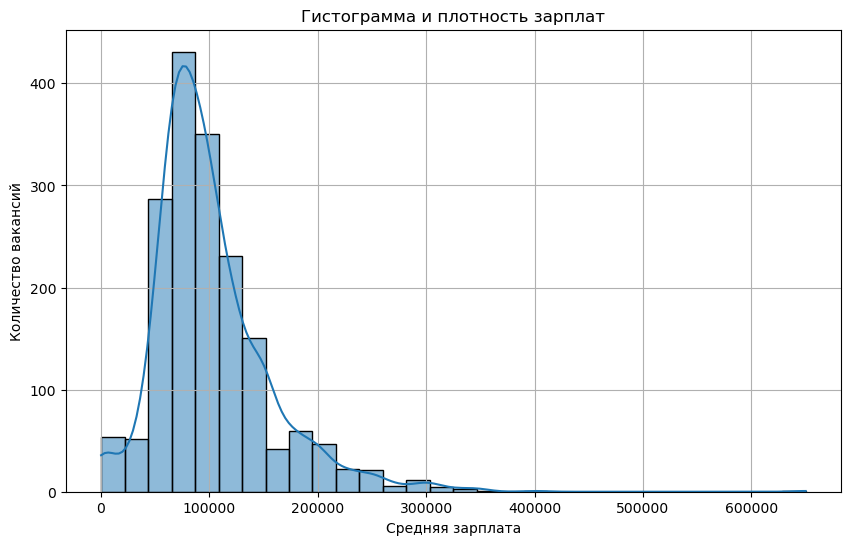

In [6]:
plt.figure(figsize=(10, 6))

# Гистограмма + плотность
sns.histplot(df_salary['salary_avg'], kde=True, bins=30)

plt.title('Гистограмма и плотность зарплат')
plt.xlabel('Средняя зарплата')
plt.ylabel('Количество вакансий')
plt.grid(True)
plt.show()